# Практическая работа 3 АЗСИИ

Костомахин Антон Александрович ББМО-02-23

Импортирование библиотек

In [3]:
# Импорт необходимых библиотек
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

Загрузка уже обученной модели и данных MNIST для их использования в атаке

In [4]:
import os
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
import numpy as np

# Проверяем, существует ли файл модели
model_path = 'mnist_model.h5'

if not os.path.exists(model_path):
    print("Файл модели не найден. Создаём и обучаем новую модель...")

    # Загрузка данных MNIST
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    # Нормализация данных
    x_train, x_test = x_train / 255.0, x_test / 255.0

    # Создание простой модели
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(128, activation='relu'),
        Dense(10, activation='softmax')
    ])

    # Компиляция и обучение модели
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

    # Сохранение обученной модели
    model.save(model_path)
    print(f"Модель сохранена в {model_path}")
else:
    print(f"Файл модели найден: {model_path}")

# Загрузка модели
pretrained_model = tf.keras.models.load_model(model_path)

# Загрузка тестового набора данных
(_, _), (mnist_images, mnist_labels) = mnist.load_data()

# Нормализация данных
mnist_images = mnist_images.astype("float32") / 255.0

# Проверяем точность модели на исходных данных
loss, accuracy = pretrained_model.evaluate(mnist_images, mnist_labels, verbose=0)
print(f'Accuracy on clean dataset: {accuracy:.4f}')


Файл модели не найден. Создаём и обучаем новую модель...
Epoch 1/5


C:\Users\zazax\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.8795 - loss: 0.4280 - val_accuracy: 0.9627 - val_loss: 0.1304
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9665 - loss: 0.1160 - val_accuracy: 0.9666 - val_loss: 0.1040
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9769 - loss: 0.0768 - val_accuracy: 0.9753 - val_loss: 0.0851
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9832 - loss: 0.0563 - val_accuracy: 0.9768 - val_loss: 0.0732
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9868 - loss: 0.0450 - val_accuracy: 0.9778 - val_loss: 0.0713


Модель сохранена в mnist_model.h5
Accuracy on clean dataset: 0.9778


После установки Foolbox "pip install foolbox" делаем реализацию атаки

Реализация атаки Carlini-Wagner

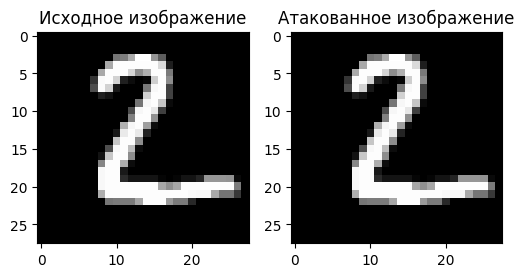

In [13]:
import foolbox as fb

# Инициализация Foolbox для работы с TensorFlow
foolbox_model = fb.TensorFlowModel(pretrained_model, bounds=(0, 1))

# Выбираем одно изображение для анализа
target_image = tf.convert_to_tensor(mnist_images[1:2], dtype=tf.float32)
original_label = tf.convert_to_tensor(np.argmax(mnist_labels[1]), dtype=tf.int64)

# Выполняем атаку с использованием L2 Carlini & Wagner
cw_attack = fb.attacks.L2CarliniWagnerAttack(steps=3)
perturbed_image = cw_attack(foolbox_model, target_image, original_label[None], epsilons=0.2)

# Визуализация результата атаки
plt.figure(figsize=(6, 8))
plt.subplot(1, 2, 1)
plt.title("Исходное изображение")
plt.imshow(target_image[0].numpy(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("Атакованное изображение")
plt.imshow(perturbed_image[0][0].numpy(), cmap="gray")
plt.show()


Оценка модели на противоречивых примерах

In [14]:
import tensorflow as tf
import numpy as np

# Создание множества атакованных изображений для оценки модели
adversarial_set = []
subset_size = 100  # Ограничиваем количество изображений для оптимизации
batch_size = 10    # Размер батча

# Обработка изображений батчами
for i in range(0, subset_size, batch_size):
    # Подготовка батча изображений и меток
    batch_images = tf.convert_to_tensor(mnist_images[i:i+batch_size], dtype=tf.float32)
    batch_labels = tf.convert_to_tensor([np.argmax(mnist_labels[j]) for j in range(i, i+batch_size)], dtype=tf.int64)
    
    # Атака на текущий батч
    perturbed_samples, _, success = cw_attack(foolbox_model, batch_images, batch_labels, epsilons=0.1)
    adversarial_set.append(perturbed_samples)

# Конкатенация всех атакованных изображений в один набор
adversarial_set = tf.concat(adversarial_set, axis=0)

# Оценка точности модели на атакованных изображениях
adv_loss, adv_accuracy = pretrained_model.evaluate(adversarial_set, mnist_labels[:subset_size], verbose=0)
print(f'Model accuracy on adversarial dataset: {adv_accuracy:.4f}')


Model accuracy on adversarial dataset: 0.9200


Значение точности 0.9200 на адверсариальных примерах говорит о том, что модель испытывает определённые трудности при обработке атакованных данных, что может указывать на её уязвимость. Несмотря на высокую точность на обычных данных, способность модели справляться с атакующими примерами значительно снижена, что делает её подверженной угрозам в реальных условиях эксплуатации. Это может быть серьёзной проблемой, особенно в приложениях, где безопасность и надёжность модели имеют критическое значение.